# **Clustering**

### **Import** section

In [1]:
from random import sample
import numpy as np
import pandas as pd
import itertools
pd.set_option('display.expand_frame_repr', False)

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.cluster import KMeans, DBSCAN

---
### Text **normalization**

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import re

#nltk.download('stopwords')
#nltk.download('punkt')
ps = PorterStemmer()

def itemParser(s):
    
    s = s.replace("\n", "")
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r"(\d)", "", s)
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(u'\w*\u2122', '', s)

    s = s.lower()

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(s)

    filtered_sentence = [ps.stem(w) for w in word_tokens if not w in stop_words]
    s = ' '.join(filtered_sentence)
    
    return s

---
## **Read** dataset and **Mapping**

In [11]:
superm = []
baskets = []
with open('../Data/groceries_norm.csv', 'r') as f:
    for line in f:
        basket = []
        line = line.replace('\n', '')
        items = line.split(",")
        for item in items:
            #parsed = itemParser(item)
            superm.append(item)
            basket.append(item)
        baskets.append(basket)

In [12]:
products = list(set(superm))

In [13]:
# Mapping
elems = set()
for b in baskets:
    elems.update(b)

mapping = {}
reverseMapping = {}
key = 0
for e in elems:
    mapping[e] = key
    reverseMapping[key] = e
    key += 1

In [14]:
singletons = {}
for b in baskets:
    for item in b:
        if item not in singletons.keys():
            singletons[item] = 0
        singletons[item] += 1

---
### Dataset **Transformations** - (*One Hot Encoder*)

In [15]:
ohe_baskets = []
for basket in baskets:
    ohe = [0 for _ in range(len(mapping))]
    for item in basket:
        ohe[mapping[item]] = 1
    ohe_baskets.append(ohe)

In [16]:
pd_ohe = pd.DataFrame(ohe_baskets)
display(pd_ohe)

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9832,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9833,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


---
## **Tests**

### Basket size count

In [17]:
maxlen = 0
for b in baskets:
    if len(b) > maxlen:
        maxlen = len(b)
        
count = [0 for _ in range(maxlen + 1)]
for b in baskets:
    count[len(b)] += 1

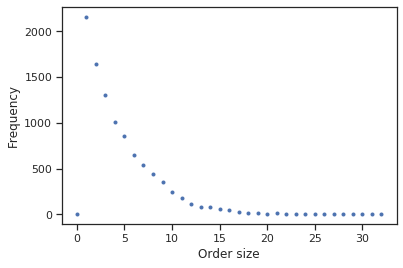

In [18]:
plt.ylabel("Frequency")
plt.xlabel("Order size")
plt.plot(count, ".")

### **PCA** > Clustering

In [19]:
pca = PCA(n_components=5)
pcat = pca.fit_transform(pd_ohe)
principalDf = pd.DataFrame(data=pcat)

#### Analysis

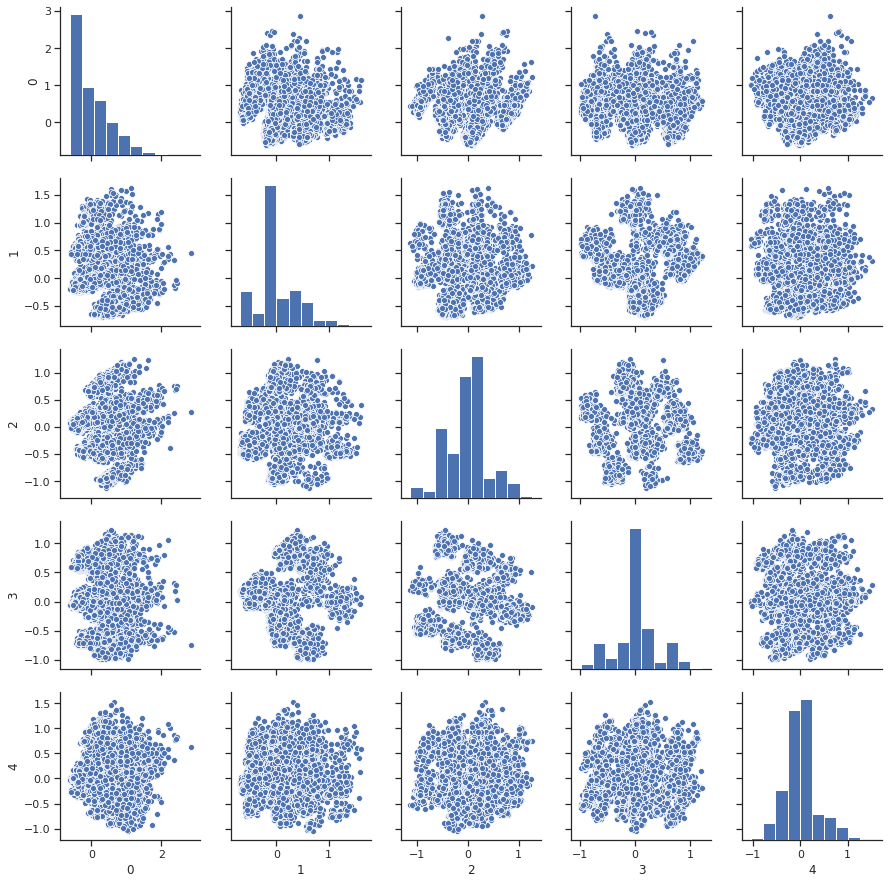

In [20]:
g = sns.pairplot(principalDf)

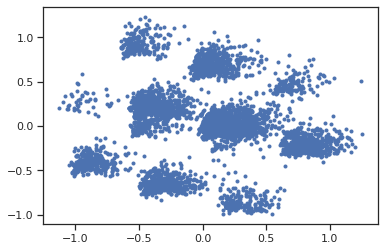

In [21]:
# Details
xx = list(principalDf[2])
yy = list(principalDf[3])

plt.scatter(xx, yy, marker=".")

In [22]:
# Select only the discriminative columns
interessanti = principalDf.loc[:,2:3]

### **KMeans**

In [ ]:
'''
kmeans = KMeans(n_clusters=10).fit(interessanti)
centroids = kmeans.cluster_centers_
print(centroids)
'''

In [24]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(principalDf)
    distortions.append(kmeanModel.inertia_)

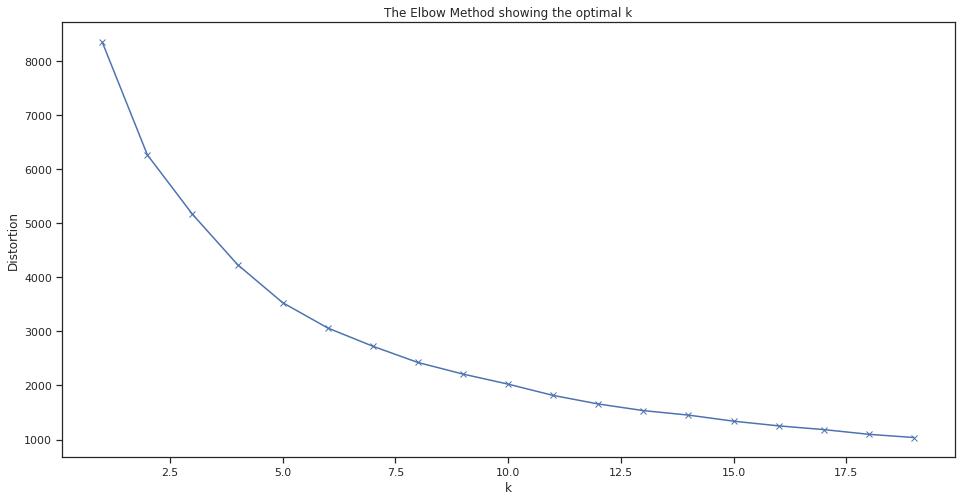

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [26]:
kmeanModel = KMeans(n_clusters=10)
kmeanModel.fit(principalDf.loc[:,2:3])
predicted = list(kmeanModel.predict(principalDf.loc[:,2:3]))

In [28]:
interessanti['Cluster'] = pd.Series(predicted)

/home/elia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


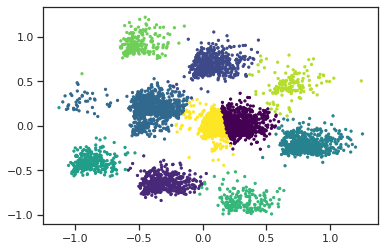

In [29]:
plt.scatter(xx, yy, c=predicted, s=5, cmap='viridis')

### **DBSCAN**

In [30]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(principalDf)

In [31]:
#np.unique(dbscan)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('n clust:', n_clusters_)
print('n noise:', n_noise_)

n clust: 6
n noise: 5


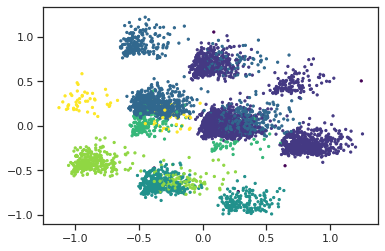

In [32]:
xx = list(principalDf[2])
yy = list(principalDf[3])

plt.scatter(xx, yy, c=labels, s=5, cmap='viridis')

---
## Clustering **Analysis**

In [33]:
clusteredBasket = list(zip(baskets, predicted))

In [34]:
def countItems(lista, top):
    counting = {}
    for items in lista:
        for item in items:
            if item not in counting.keys():
                counting[item] = 0
            counting[item] += 1
            
    counting = [(k, v) for k, v in sorted(counting.items(), key=lambda item: item[1], reverse=True)]
    tops = counting[:top]
    
    for (k, v) in tops:
        print("      " + str(k) + " [" + str(v) + "]")

In [35]:
pdClusteredBasket = pd.DataFrame(clusteredBasket, columns=["Basket", "Cluster"])
pdClusteredBasket

,Basket,Cluster
0,"[citru fruit, semifinish bread, margarin, read...",9
1,"[tropic fruit, yogurt, coffe]",0
2,[whole milk],3
3,"[pip fruit, yogurt, cream chees, meat spread]",0
4,"[veget, whole milk, condens milk, long life ba...",9
...,...,...
9830,"[sausag, chicken, beef, hamburg meat, citru fr...",9
9831,[cook chocol],9
9832,"[chicken, citru fruit, veget, butter, yogurt, ...",6
9833,"[semifinish bread, bottl water, soda, bottl beer]",2


In [36]:
# Single Cluster Analysis
clusters = []
for i in range(10):
    clusters.append(pdClusteredBasket.loc[pdClusteredBasket['Cluster'] == i]) 

In [37]:
# Top 10 cluster items
for i in range(10):
    print("Cluster " + str(i+1) + ":")
    countItems(list(clusters[i]["Basket"]), 10)

Cluster 1:
      root veget [354]
      veget [343]
      whole milk [321]
      yogurt [268]
      tropic fruit [243]
      citru fruit [227]
      pip fruit [194]
      shop bag [168]
      whippedsour cream [151]
      bottl water [126]
Cluster 2:
      rollsbun [895]
      yogurt [125]
      whole milk [123]
      veget [117]
      sausag [116]
      frankfurt [99]
      tropic fruit [94]
      newspap [87]
      bottl water [83]
      root veget [79]
Cluster 3:
      soda [984]
      bottl water [160]
      shop bag [122]
      yogurt [113]
      bottl beer [105]
      fruitveget juic [101]
      whole milk [95]
      pastri [91]
      sausag [90]
      tropic fruit [88]
Cluster 4:
      whole milk [1230]
      rollsbun [305]
      soda [305]
      yogurt [241]
      bottl water [174]
      sausag [173]
      tropic fruit [166]
      root veget [164]
      pastri [160]
      newspap [146]
Cluster 5:
      veget [808]
      root veget [169]
      yogurt [142]
      tropic fruit [12